In [1]:
import matplotlib.pyplot as plt
import scipy.stats as sts
import scipy.signal as sigs
import numpy as np
import cmdstanpy ## import stan interface for Python
import os
import seaborn as sns
import pandas as pd
from importlib import reload 
import sys
sys.path.append("..")
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")
from statannotations.Annotator import Annotator
from itertools import product

tex_fonts = {
    # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "Helvetica",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 7,
    "font.size": 7,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 6,
    "xtick.labelsize": 6,
    "ytick.labelsize": 4,
    "axes.grid": True,
    'grid.color': '#DDDDDD',
    'grid.linestyle': '-',
    'grid.linewidth': 0.3,
    "lines.markersize":5,
    "lines.markeredgewidth":1,
    'axes.axisbelow':True,
    'pdf.fonttype':42,
    'axes.linewidth':0.5,
        'xtick.major.width':0.5,
    'ytick.major.width':0.5,
    'ytick.minor.width':0.3,

    'ytick.major.pad':0.2,
        "xtick.major.size":3,
    "ytick.major.size":3,
}

plt.rcParams.update(tex_fonts)

if os.name == "nt": ## adds compiler to path in Windows
    cmdstanpy.utils.cxx_toolchain_path() 
    
%config InlineBackend.close_figures=False # keep figures open in pyplot
#%config InlineBackend.print_figure_kwargs = {'bbox_inches':"tight", 'pad_inches':2}

np.random.seed(2101)


ratio= 2/(1+np.sqrt(5))

width = 520.344

kwags = {"wspace":0.2}

my_pal = {"4cm": "g", 
          "4em": "m", 
          "Donor":"#a4e0ef", 
          "Host":"#ff7f0e",
         "WT":"#02feff",
         "Young":"#7d81fc",
         "Old":"#f50aff"}

my_marks = {"Donor": "o", 
           "Host": "X",
         "WT":"o",
         "Young CHIM":"P",
         "Old CHIM":"^"}

scatterkwags = {"palette": my_pal,
                  "markers":my_marks,
                  'edgecolor':"k",
}


def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    #golden_ratio = (5**.5 - 1) / 2
    golden_ratio = 1

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

#loading dataframes for parameters and data
df_para = pd.read_csv('/home/elise/Code/BRDU/parameters_est.csv')
df = pd.read_csv('/home/elise/Code/BRDU/Elisehasbeenusing_dataUCL.csv',index_col='index')
df['age_cat']=np.where(df.age < 114, 'wt', pd.np.where((df.age >= 114) & (df.age < 180), 'Young', 'Old'))

def enumerated_product(*args):
    yield from zip(product(*(range(len(x)) for x in args)), product(*args))

def myMAP(data):
    
#     counts, x = np.histogram(data,bins=(np.int(np.rint(np.sqrt(len(data))))))
#     x_ind = np.unravel_index(np.argmax(counts), counts.shape)
# #     arrayed = data.to_numpy()

# #     i_peaks, _ = sigs.find_peaks(arrayed)

# #     i_peaks
# #     arrayed[i_peaks]

# #     # Find the index from the maximum peak
# #     i_max_peak = i_peaks[np.argmax(_['widths'])]

# #     # Find the x value from that index
# #     x_max = arrayed[i_max_peak]


# #     # Find the x value from that index
# #     x_max = arrayed[i_max_peak]
#     return x[x_ind]

    arrayed = data.to_numpy()
    nparam_density = sts.kde.gaussian_kde(arrayed)
    x = np.linspace(np.min(arrayed), np.max(arrayed), 2000)
    nparam_density = nparam_density(x)

    return x[np.argsort(nparam_density)[-1]]

In [2]:
youngfile = '/opt/mesh/tiree/elise/samples_1/youngmice_r18/stan-cache-'
oldfile = '/opt/mesh/tiree/elise/samples_1/oldmice_r25/stan-cache-'

# parnames = ["alpha_A","alpha_B","delta_A","delta_B","beta","Source","mu","eff"] 
# pretty_parnames = ["$\\alpha$_A","$\\alpha$_B","$\\delta$_A", "$\\delta$_B","$\\beta$","Source","$\\mu$","$\\epsilon$"] #

# parnames_L = ["alpha_A","alpha_B","delta_A","delta_B","beta","Source","mu","eff","gamma"] 
# pretty_parnames_L = ["$\\alpha$_A","$\\alpha$_B","$\\delta$_A", "$\\delta$_B","$\\beta$","Source","$\\mu$","$\\epsilon$","$\\gamma$"] #

# parnames_B = ["alpha_A","alpha_B","delta_A","delta_B","beta","Source","mu","eff","fs"] 
# pretty_parnames_B = ["$\\alpha$_A","$\\alpha$_B","$\\delta$_A", "$\\delta$_B","$\\beta$","Source","$\\mu$","$\\epsilon$","fs"] #

# parnames = ["alpha_A","alpha_B","delta_A","delta_B","Source","mu","eff"] 
# pretty_parnames = ["$\\alpha$_A","$\\alpha$_B","$\\delta$_A", "$\\delta$_B","Source","$\\mu$","$\\epsilon$"] #

# parnames_L = ["alpha_A","alpha_B","delta_A","delta_B","Source","mu","eff","gamma"] 
# pretty_parnames_L = ["$\\alpha$_A","$\\alpha$_B","$\\delta$_A", "$\\delta$_B","Source","$\\mu$","$\\epsilon$","$\\gamma$"] #

# parnames_B = ["alpha_A","alpha_B","delta_A","delta_B","Source","mu","eff","fs"] 
# pretty_parnames_B = ["$\\alpha$_A","$\\alpha$_B","$\\delta$_A", "$\\delta$_B","Source","$\\mu$","$\\epsilon$","fs"] #

parnames = ["alpha_A","alpha_B","delta_A","delta_B","beta","mu","eff"] 
pretty_parnames = ["$\\alpha$_A","$\\alpha$_B","$\\delta$_A", "$\\delta$_B","$\\beta$","$\\mu$","$\\epsilon$"] #

parnames_L = ["alpha_A","alpha_B","delta_A","delta_B","beta","mu","eff","gamma"] 
pretty_parnames_L = ["$\\alpha$_A","$\\alpha$_B","$\\delta$_A", "$\\delta$_B","$\\beta$","$\\mu$","$\\epsilon$","$\\gamma$"] #

parnames_B = ["alpha_A","alpha_B","delta_A","delta_B","beta","mu","eff","fs"] 
pretty_parnames_B = ["$\\alpha$_A","$\\alpha$_B","$\\delta$_A", "$\\delta$_B","$\\beta$","$\\mu$","$\\epsilon$","fs"] #


pardf = pd.DataFrame()

ADHc = ['host','donor']
populationc = ['4cm','4em']
agec = ['Young CHIM','Old CHIM']

for idx, adhpop in enumerated_product(ADHc,populationc, agec):
    fl = []
    fb = []
    
    #data slicing and manulipulation
    if adhpop[2]=='Young CHIM':
        location = youngfile+adhpop[1]+adhpop[0]+'_1/'
    else:
        location = oldfile+adhpop[1]+adhpop[0]+'_1/'

    sys.path.insert(1, location)
    import paras
    reload(paras)

    for f_name in os.listdir(location):
        if f_name.endswith('.csv')&f_name.startswith('branched'):
            print(f_name)
            fb.append(location+f_name)
        elif f_name.endswith('.csv')&f_name.startswith('linear'):
            print(f_name)
            fl.append(location+f_name)

    sam_fb = cmdstanpy.from_csv(fb)
    sam_fl = cmdstanpy.from_csv(fl)
            

    parests_flvl = [sam_fl.stan_variable(pn) for pn in parnames_L]
    parests_fbvl = [sam_fb.stan_variable(pn) for pn in parnames_B]

    k_hat_fl =  sam_fl.stan_variable("k_hat")
    kihi_fl =  sam_fl.stan_variable("f_kihi_calc")
    k_hat_fb =  sam_fb.stan_variable("k_hat")
    kihi_fb =  sam_fb.stan_variable("f_kihi_calc")
    
    pardf_lvl=pd.DataFrame(np.transpose(parests_flvl), columns = parnames_L)
    pardf_lvl['type']='linear'
    pardf_lvl['population']=paras.populationc
    pardf_lvl['doh']=paras.ADHc
    pardf_lvl['popdoh']=paras.populationc+paras.ADHc
    pardf_lvl['ones']=1
    pardf_lvl['age']=adhpop[2]
    pardf_lvl['alpha_adata']=1/paras.alpha_A
    pardf_lvl['alpha_bdata']=1/paras.alpha_B
    pardf_lvl['delta_adata']=1/paras.delta_A
    pardf_lvl['delta_bdata']=1/paras.delta_B
    pardf_lvl['betadata']=1/paras.beta
    pardf_lvl['effdata']=paras.eff
    pardf_lvl['mudata']=paras.mu
    pardf_lvl['sourcedata']=paras.SourceL
    pardf_lvl['counts_t0']=paras.counts_t0
    pardf_lvl['Source']=np.random.normal(paras.SourceL,0.001, len(k_hat_fl))
    pardf_lvl['FastSlowRatio']=np.mean(np.sum(k_hat_fl[:,:,0:paras.switch],axis=2), axis=1)/np.mean(np.sum(k_hat_fl[:,:,paras.switch:],axis=2), axis=1)
    pardf_lvl['FastCount']=np.mean(np.sum(k_hat_fl[:,:,0:paras.switch],axis=2), axis=1)
    pardf_lvl['TotalCount']=np.mean(np.sum(k_hat_fl[:,:,:],axis=2), axis=1)
    pardf_lvl['KihiFrac'] = np.mean(kihi_fl,axis=1)
    pardf_lvl['KihiFracinFast'] =np.mean(np.sum(k_hat_fl[:,:,:((2+paras.numofbrduint)*(1+paras.numofki67int))],axis=2),axis=1)/pardf_lvl['FastCount']
    pardf_lvl['KihiFracinSlow'] =np.mean(np.sum(k_hat_fl[:,:,(paras.switch):(paras.switch+(2+paras.numofbrduint)*(1+paras.numofki67int))],axis=2),axis=1)/(pardf_lvl['TotalCount']-pardf_lvl['FastCount'])
    pardf_lvl["fs"]=np.random.normal(1.1,0.001, len(k_hat_fl))
    pardf_lvl['FastFraction']=np.mean(np.sum(k_hat_fl[:,:,0:paras.switch],axis=2), axis=1)/np.mean(np.sum(k_hat_fl[:,:,:],axis=2), axis=1)
    pardf_lvl["Source_B"] = pardf_lvl["gamma"]*np.mean(np.sum(k_hat_fl[:,:,0:paras.switch],axis=2), axis=1)
    pardf_lvl["Source_A"] = pardf_lvl["Source"]
    pardf_lvl["Frac_Source_A"] = np.random.normal(1,0.001, len(k_hat_fl))

    pardf_bvl=pd.DataFrame(np.transpose(parests_fbvl), columns = parnames_B)
    pardf_bvl['type']='branched'
    pardf_bvl['population']=paras.populationc
    pardf_bvl['doh']=paras.ADHc
    pardf_bvl['popdoh']=paras.populationc+paras.ADHc
    pardf_bvl['ones']=1
    pardf_bvl['age']=adhpop[2]
    pardf_bvl['alpha_adata']=1/paras.alpha_A
    pardf_bvl['alpha_bdata']=1/paras.alpha_B
    pardf_bvl['delta_adata']=1/paras.delta_A
    pardf_bvl['delta_bdata']=1/paras.delta_B
    pardf_bvl['betadata']=1/paras.beta
    pardf_bvl['effdata']=paras.eff
    pardf_bvl['mudata']=paras.mu
    pardf_bvl['sourcedata']=paras.SourceB
    pardf_bvl['counts_t0']=paras.counts_t0
    pardf_bvl['Source']=np.random.normal(paras.SourceB,0.001, len(k_hat_fb))
    pardf_bvl['FastSlowRatio']=np.mean(np.sum(k_hat_fb[:,:,0:paras.switch],axis=2), axis=1)/np.mean(np.sum(k_hat_fb[:,:,paras.switch:],axis=2), axis=1)
    pardf_bvl['FastCount']=np.mean(np.sum(k_hat_fb[:,:,0:paras.switch],axis=2), axis=1)
    pardf_bvl['TotalCount']=np.mean(np.sum(k_hat_fb[:,:,:],axis=2), axis=1)
    pardf_bvl['KihiFrac'] = np.mean(kihi_fb,axis=1)
    pardf_bvl['KihiFracinFast'] =np.mean(np.sum(k_hat_fb[:,:,:((2+paras.numofbrduint)*(1+paras.numofki67int))],axis=2),axis=1)/pardf_bvl['FastCount']
    pardf_bvl['KihiFracinSlow'] =np.mean(np.sum(k_hat_fb[:,:,(paras.switch):(paras.switch+(2+paras.numofbrduint)*(1+paras.numofki67int))],axis=2),axis=1)/(pardf_bvl['TotalCount']-pardf_bvl['FastCount'])

    pardf_bvl['FastFraction']=np.mean(np.sum(k_hat_fb[:,:,0:paras.switch],axis=2), axis=1)/np.mean(np.sum(k_hat_fb[:,:,:],axis=2), axis=1)
    pardf_bvl["Source_B"] = (1-pardf_bvl["fs"])*pardf_bvl["Source"]
    pardf_bvl["Source_A"] = (pardf_bvl["fs"])*pardf_bvl["Source"]
    pardf_bvl["Frac_Source_A"] = pardf_bvl["fs"]
    pardf_bvl["gamma"]=0
    
    pardf = pd.concat([pardf,pardf_lvl, pardf_bvl])
#     pardf = pd.concat([pardf,pardf_bvl])



pardf["inv_alpha_A"] = pardf["ones"].div(pardf["alpha_A"].values)
pardf["inv_alpha_B"] = pardf["ones"].div(pardf["alpha_B"].values)
pardf["inv_delta_A"] = pardf["ones"].div(pardf["delta_A"].values)
pardf["inv_delta_B"] = pardf["ones"].div(pardf["delta_B"].values)
pardf["inv_beta"] = pardf["ones"].div(pardf["beta"].values)
pardf["frac_source"] = pardf["Source"].div(pardf["counts_t0"].values)
pardf["lambda_A"] = pardf["gamma"]+(pardf["delta_A"] - pardf["alpha_A"])
pardf["lambda_B"] = pardf["delta_B"] - pardf["alpha_B"]
pardf["ratio_lambda"] = pardf["lambda_A"]/(pardf["lambda_B"])
pardf["calc_fract"] = 1/(((1-pardf["fs"])/pardf["fs"])*pardf["ratio_lambda"] +1)
pardf["ratiofs"] = ((1-pardf["fs"])/pardf["fs"])


pardf["fastcellsurvival"] = abs(pardf["gamma"].div(pardf["gamma"]+pardf["delta_A"]))
pardf["averagetimeinfast"]=pardf["ones"].div(pardf["gamma"]+pardf["delta_A"])
pardf["clonallifetimeinfast"]=pardf["ones"].div(pardf["gamma"]+pardf["delta_A"]-pardf["alpha_A"])


# pardf.loc[(pardf['population']=='4cm')&(pardf['type']=='branched'),"chimera"] = pardf[(pardf['popdoh']=='4cmDonor')&(pardf['type']=='branched')].Source/(pardf[(pardf['popdoh']=='4cmDonor')&(pardf['type']=='branched')].Source+pardf[(pardf['popdoh']=='4cmHost')&(pardf['type']=='branched')].Source)

# pardf.loc[(pardf['population']=='4cm')&(pardf['type']=='linear'),"chimera"] = pardf[(pardf['popdoh']=='4cmDonor')&(pardf['type']=='linear')].Source/(pardf[(pardf['popdoh']=='4cmDonor')&(pardf['type']=='linear')].Source+pardf[(pardf['popdoh']=='4cmHost')&(pardf['type']=='linear')].Source)

# pardf.loc[(pardf['population']=='4em')&(pardf['type']=='branched'),"chimera"] = pardf[(pardf['popdoh']=='4emDonor')&(pardf['type']=='branched')].Source/(pardf[(pardf['popdoh']=='4emDonor')&(pardf['type']=='branched')].Source+pardf[(pardf['popdoh']=='4emHost')&(pardf['type']=='branched')].Source)

# pardf.loc[(pardf['population']=='4em')&(pardf['type']=='linear'),"chimera"] = pardf[(pardf['popdoh']=='4emDonor')&(pardf['type']=='linear')].Source/(pardf[(pardf['popdoh']=='4emDonor')&(pardf['type']=='linear')].Source+pardf[(pardf['popdoh']=='4emHost')&(pardf['type']=='linear')].Source)


ADHc = ['host','donor']
populationc = ['4cm','4em']
agec = ['Young CHIM','Old CHIM']
typec = ['branched','linear']
ys = ["Source","Frac_Source_A","FastFraction","calc_fract","alpha_A","delta_A","alpha_B","delta_B","lambda_A",
"lambda_B","KihiFrac","ratio_lambda","ratiofs", "KihiFracinFast","KihiFracinSlow",]

for idx, adhpop in enumerated_product(populationc, agec, typec,ys):

    pardf.loc[(pardf['population']==adhpop[0])
              &(pardf['type']==adhpop[2])
              &(pardf['age']==adhpop[1]),adhpop[3]+"_diffdoh"] = pardf[(pardf['popdoh']==adhpop[0]+'donor')&
                                                            (pardf['type']==adhpop[2])&
                                                            (pardf['age']==adhpop[1])][adhpop[3]] - (pardf[(pardf['popdoh']==adhpop[0]+'host')&
                                                                                                            (pardf['type']==adhpop[2])&
                                                                                                            (pardf['age']==adhpop[1])][adhpop[3]])

    
for idx, adhpop in enumerated_product(populationc, ADHc, typec,ys):

    pardf.loc[(pardf['population']==adhpop[0])
              &(pardf['type']==adhpop[2])
              &(pardf['doh']==adhpop[1]),adhpop[3]+"_diffage"] = pardf[(pardf['age']=='Young CHIM')&
                                                            (pardf['type']==adhpop[2])&(pardf['population']==adhpop[0])&
                                                            (pardf['doh']==adhpop[1])][adhpop[3]] - (pardf[(pardf['age']=='Old CHIM')&
                                                                                                            (pardf['type']==adhpop[2])&(pardf['population']==adhpop[0])&
                                                                                                            (pardf['doh']==adhpop[1])][adhpop[3]])
pardf = pardf[(pardf.ratio_lambda < 50)]

pardf['age'] = pardf['age'].replace('Young CHIM','Young')
pardf['age'] = pardf['age'].replace('Old CHIM','Old')

pardf['doh'] = pardf['doh'].replace('donor','Donor')
pardf['doh'] = pardf['doh'].replace('host','Host')

linearrealyoung-20240104164843_1.csv
branchedrealyoung-20240104164848_4.csv
branchedrealyoung-20240104164848_1.csv
branchedrealyoung-20240104164848_5.csv
branchedrealyoung-20240104164848_2.csv
linearrealyoung-20240104164843_5.csv
linearrealyoung-20240104164843_3.csv
linearrealyoung-20240104164843_4.csv
branchedrealyoung-20240104164848_3.csv
linearrealyoung-20240104164843_2.csv
linearrealold-20230912111553_5.csv
branchedrealold-20230912111553_3.csv
branchedrealold-20230912111553_2.csv
linearrealold-20230912111553_4.csv
branchedrealold-20230912111553_4.csv
linearrealold-20230912111553_2.csv
linearrealold-20230912111553_3.csv
linearrealold-20230912111553_1.csv
branchedrealold-20230912111553_1.csv
branchedrealold-20230912111553_5.csv
linearrealyoung-20240104164859_4.csv
branchedrealyoung-20240104164909_3.csv
linearrealyoung-20240104164859_2.csv
linearrealyoung-20240104164859_3.csv
branchedrealyoung-20240104164909_4.csv
branchedrealyoung-20240104164909_2.csv
branchedrealyoung-20240104164909

In [3]:
from scipy.stats import mannwhitneyu
def ustat(pairs):
    x = 'doh'
    pvalues = []
    for pair in pairs:
        df1 = df[(df['age'] == pair[0][0])]
        data1 = df1.groupby(x)[y].get_group(pair[0][1])
        data2 = df1.groupby(x)[y].get_group(pair[1][1])
        stat1, p1 = mannwhitneyu(data1, data2)
        stat2, p2 = mannwhitneyu(data2, data1)
        stat = min(stat1,stat2)
    #         print((data1))
        calcp = stat/(len(data1)*len(data2))
#         print("Mann Whitney Ustat calculated p:",
#               pair, "stat={:.2e} p-value={:.2e}".format(stat, p))
        pvalues.append(calcp)
#     print("pvalues:", pvalues)
    
    return pvalues

In [4]:
typec = ['branched']
popc = ["4cm","4em"]
ys = ["Frac_Source_A","alpha_A","delta_A","alpha_B","delta_B","lambda_A","lambda_B","calc_fract"]
nice_ys = ["$F_A$","$\\alpha_A$","$\\alpha_B$","$\\delta_A$", "$\\delta_B$","$\\lambda_A$", "$\\lambda_B$","Ki67 Frac"]
pardf['age'] = pardf['age'].replace('Young CHIM','Young')
pardf['age'] = pardf['age'].replace('Old CHIM','Old')

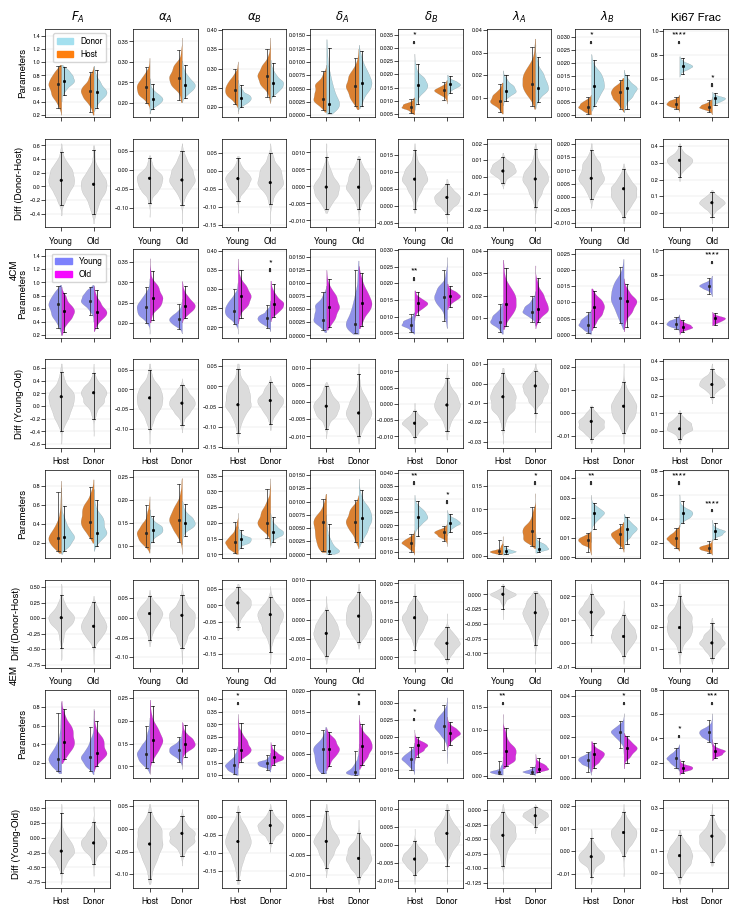

In [5]:

fig, axes = plt.subplots(8, len(ys), figsize=(7.2,9))


pairs = [(("Young", "Host"), ("Young", "Donor")),(("Old", "Host"), ("Old", "Donor"))]


for idx, adhpop in enumerated_product(typec,popc):
    pop_i = adhpop[1]
    df = pardf[(pardf['type'] == adhpop[0])&(pardf['population'] == pop_i)]
    
    pointplotkwags = {"data":pardf[(pardf['type'] == adhpop[0])&(pardf['population'] == pop_i)],
                      "x":"age",
                      "hue":"doh",
                      "dodge":0.2, 
                      "join":False, 
                      #"palette":my_pal, 
                      "color":"k",
                      "estimator": myMAP, 
                      "errorbar":('pi', 97.5),
                      #"ci":97.5,                  
                      "capsize":0.1,
                      "errwidth":.5,
                      "scale":0.25
                     }

    violinplotkwags = {"data":pardf[(pardf['type'] == adhpop[0])&(pardf['population'] == pop_i)],
                       "x":"age",
                       "hue":"doh",
                       "saturation":0.7, 
                       "split":True, 
                       "inner":None,
                       "palette":my_pal,
                       "linewidth":0.1,
                       "cut":0,
                       "scale":"width",
                       "orient":"v"
                      }
    pointplotkwags_diff = {"data":pardf[(pardf['type'] == adhpop[0])&(pardf['population'] == pop_i)],
                      "x":"age",
                      "join":False, 
                      "color":"k",
                      "estimator": myMAP, 
                      "errorbar":('pi', 97.5),
                      #"ci":97.5,                  
                      "capsize":0.1,
                      "errwidth":.5,
                      "scale":0.25
                     }

    violinplotkwags_diff = {"data":pardf[(pardf['type'] == adhpop[0])&(pardf['population'] == pop_i)],
                       "x":"age",
                       "saturation":0.7, 
                       "inner":None,
                       "linewidth":0.1,
                        "color":"#DCDCDC",
                       "cut":0,
                       "scale":"width",
                       "orient":"v"
                      }
    annotatorkwags = {"pairs":[(("Young"), ("Young")),
                               (("Old"), ("Old"))],
                      "data":pardf[(pardf['type'] == adhpop[0])&(pardf['population'] == pop_i)],
                      "x":"age",
                      "plot":'violinplot',
                      "engine":"seaborn",
                      "hide_non_significant":True,
                      "verbose":False
                     }

    for idy, yss in enumerated_product(ys):
        y = yss[0]
        viol=sns.violinplot(ax=axes[idx[0]+4*idx[1],idy[0]], y=y, **violinplotkwags)
        sns.pointplot(ax=axes[idx[0]+4*idx[1],idy[0]],y=y,**pointplotkwags)
        annot = Annotator(ax=axes[idx[0]+4*idx[1],idy[0]],y=y, **annotatorkwags)
        annot.configure(test=None, comparisons_correction=None, text_format='star', loc='inside')
        annot.set_pvalues(pvalues=ustat(pairs))
        annot.annotate()
#         axes[idx[0],idy[0]].set_yscale('log')
        axes[idx[0]+4*idx[1],idy[0]].set_ylabel('')

        axes[idx[0]+4*idx[1],idy[0]].set_xlabel('')
        axes[idx[0]+4*idx[1],idy[0]].set_xticklabels('')
        axes[idx[0]+4*idx[1],idy[0]].legend([],[],frameon=False)
        
        axes[0,idy[0]].set_title(nice_ys[idy[0]])
        
        y = yss[0]+'_diffdoh'
        viol=sns.violinplot(ax=axes[idx[0]+1+4*idx[1],idy[0]], y=y, **violinplotkwags_diff)
        sns.pointplot(ax=axes[idx[0]+1+4*idx[1],idy[0]],y=y,**pointplotkwags_diff)
        axes[idx[0]+1+4*idx[1],idy[0]].set_ylabel('')

        axes[idx[0]+1+4*idx[1],idy[0]].set_xlabel('')
        axes[idx[0]+1+4*idx[1],idy[0]].legend([],[],frameon=False)

from scipy.stats import mannwhitneyu
def ustat(pairs):
    x = 'age'
    pvalues = []
    for pair in pairs:
        df1 = df[(df['doh'] == pair[0][0])]
        data1 = df1.groupby(x)[y].get_group(pair[0][1])
        data2 = df1.groupby(x)[y].get_group(pair[1][1])
        stat1, p1 = mannwhitneyu(data1, data2)
        stat2, p2 = mannwhitneyu(data2, data1)
        stat = min(stat1,stat2)
    #         print((data1))
        calcp = stat/(len(data1)*len(data2))
#         print("Mann Whitney Ustat calculated p:",
#               pair, "stat={:.2e} p-value={:.2e}".format(stat, p))
        pvalues.append(calcp)
#     print("pvalues:", pvalues)
    
    return pvalues



pairs = [(("Donor", "Young"), ("Donor", "Old")),(("Host", "Young"), ("Host", "Old"))]


for idx, adhpop in enumerated_product(typec, popc):
    pop_i = adhpop[1]

    df = pardf[(pardf['type'] == adhpop[0])&(pardf['population'] == pop_i)]
    
    
    pointplotkwags = {"data":pardf[(pardf['type'] == adhpop[0])&(pardf['population'] == pop_i)],
                      "x":"doh",
                      "hue":"age",
                      "dodge":0.2, 
                      "join":False, 
                      #"palette":my_pal, 
                      "color":"k",
                      "estimator": myMAP, 
                      "errorbar":('pi', 97.5),
                      #"ci":97.5,                  
                      "capsize":0.1,
                      "errwidth":.5,
                      "scale":0.25
                     }

    violinplotkwags = {"data":pardf[(pardf['type'] == adhpop[0])&(pardf['population'] == pop_i)],
                       "x":"doh",
                       "hue":"age",
                       "saturation":0.7, 
                       "split":True, 
                       "inner":None,
                       "palette":my_pal,
                       "linewidth":0.1,
                       "cut":0,
                       "scale":"width"
                      }
    
    pointplotkwags_diff = {"data":pardf[(pardf['type'] == adhpop[0])&(pardf['population'] == pop_i)],
                      "x":"doh",
                      "join":False, 
                      #"palette":my_pal, 
                      "color":"k",
                      "estimator": myMAP, 
                      "errorbar":('pi', 97.5),
                      #"ci":97.5,                  
                      "capsize":0.1,
                      "errwidth":.5,
                      "scale":0.25
                     }

    violinplotkwags_diff = {"data":pardf[(pardf['type'] == adhpop[0])&(pardf['population'] == pop_i)],
                       "x":"doh",
                       "saturation":0.7, 
                       "inner":None,
                        "color":"#DCDCDC",
                       "linewidth":0.1,
                       "cut":0,
                       "scale":"width"
                      }
    
    annotatorkwags = {"pairs":[(("Donor"), ("Donor")),
                               (("Host"), ("Host"))],
                      "data":pardf[(pardf['type'] == adhpop[0])&(pardf['population'] == pop_i)],
                      "x":"doh",
                      "plot":'violinplot',
                      "engine":"seaborn",
                      "hide_non_significant":True,
                      "verbose":False
                     }


    for idy, yss in enumerated_product(ys):
        y = yss[0]
        viol=sns.violinplot(ax=axes[2+idx[0]+4*idx[1],idy[0]], y=y, **violinplotkwags)
        sns.pointplot(ax=axes[2+idx[0]+4*idx[1],idy[0]],y=y,**pointplotkwags)
        annot = Annotator(ax=axes[2+idx[0]+4*idx[1],idy[0]],y=y, **annotatorkwags)
        annot.configure(test=None, comparisons_correction=None, text_format='star', loc='inside')
        annot.set_pvalues(pvalues=ustat(pairs))
        annot.annotate()
        axes[2+idx[0]+4*idx[1],idy[0]].set_ylabel('')
        axes[2+idx[0]+4*idx[1],idy[0]].set_xlabel('')
        axes[2+idx[0]+4*idx[1],idy[0]].set_xticklabels('')
        axes[2+idx[0]+4*idx[1],idy[0]].legend([],[],frameon=False)
                
        y = yss[0]+'_diffage'
        viol=sns.violinplot(ax=axes[idx[0]+3+4*idx[1],idy[0]], y=y, **violinplotkwags_diff)
        sns.pointplot(ax=axes[idx[0]+3+4*idx[1],idy[0]],y=y,**pointplotkwags_diff)
        axes[idx[0]+3+4*idx[1],idy[0]].set_ylabel('')

        axes[idx[0]+3+4*idx[1],idy[0]].set_xlabel('')
        axes[idx[0]+3+4*idx[1],idy[0]].legend([],[],frameon=False)

axes[0,0].set_ylabel('Parameters')
axes[1,0].set_ylabel('Diff (Donor-Host)')

axes[2,0].set_ylabel('Parameters')
axes[3,0].set_ylabel('Diff (Young-Old)')

axes[4,0].set_ylabel('Parameters')
axes[5,0].set_ylabel('Diff (Donor-Host)')

axes[6,0].set_ylabel('Parameters')
axes[7,0].set_ylabel('Diff (Young-Old)')


plt.tight_layout(pad=0.2)

fig.text(0,0.7,'4CM',rotation='vertical')
fig.text(0,0.25,'4EM',rotation='vertical')


axes[0,0].set_ylim(top=1.5)

axes[2,0].set_ylim(top=1.5)

d = mpatches.Patch(color="#a4e0ef", label='Donor')
h = mpatches.Patch(color="#ff7f0e", label='Host')

axes[0,0].legend(handles=[d,h],loc="upper right")

d = mpatches.Patch(color="#7d81fc", label='Young')
h = mpatches.Patch(color="#f50aff", label='Old')

axes[2,0].legend(handles=[d,h],loc="upper right")


# fig.savefig('/home/elise/Dropbox/elisepaperclone/TCellMemory/Figures/fig4_all_'+typec[0]+'.pdf', dpi='figure', format='pdf',
#         bbox_inches='tight', pad_inches=0.1)

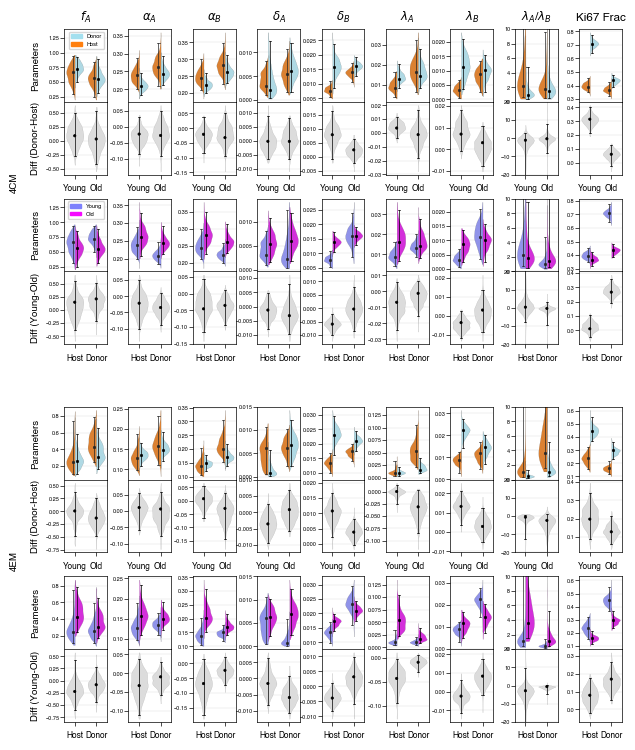

In [6]:
typec = ['branched']
popc = ["4cm","4em"]
ys = ["Frac_Source_A","alpha_A","delta_A","alpha_B","delta_B","lambda_A","lambda_B","ratio_lambda","calc_fract"]
nice_ys = ["$f_A$","$\\alpha_A$","$\\alpha_B$","$\\delta_A$", "$\\delta_B$","$\\lambda_A$", "$\\lambda_B$","$\\lambda_A$/$\\lambda_B$","Ki67 Frac"]




fig = plt.figure(figsize=(7.2,9))
spec = fig.add_gridspec(nrows=5,ncols=1,height_ratios=[1,1,0.1,1,1])

from scipy.stats import mannwhitneyu
def ustat(pairs):
    x = 'doh'
    pvalues = []
    for pair in pairs:
        df1 = df[(df['age'] == pair[0][0])]
        data1 = df1.groupby(x)[y].get_group(pair[0][1])
        data2 = df1.groupby(x)[y].get_group(pair[1][1])
        stat1, p1 = mannwhitneyu(data1, data2)
        stat2, p2 = mannwhitneyu(data2, data1)
        stat = min(stat1,stat2)
    #         print((data1))
        calcp = stat/(len(data1)*len(data2))
#         print("Mann Whitney Ustat calculated p:",
#               pair, "stat={:.2e} p-value={:.2e}".format(stat, p))
        pvalues.append(calcp)
#     print("pvalues:", pvalues)
    
    return pvalues
pairs = [(("Young", "Host"), ("Young", "Donor")),(("Old", "Host"), ("Old", "Donor"))]


for idx, adhpop in enumerated_product(typec,popc):
    pop_i = adhpop[1]
    df = pardf[(pardf['type'] == adhpop[0])&(pardf['population'] == pop_i)]
    
    pointplotkwags = {"data":pardf[(pardf['type'] == adhpop[0])&(pardf['population'] == pop_i)],
                      "x":"age",
                      "hue":"doh",
                      "dodge":0.2, 
                      "join":False, 
                      #"palette":my_pal, 
                      "color":"k",
                      "estimator": myMAP, 
                      "errorbar":('pi', 97.5),
                      #"ci":97.5,                  
                      "capsize":0.1,
                      "errwidth":.5,
                      "scale":0.25
                     }

    violinplotkwags = {"data":pardf[(pardf['type'] == adhpop[0])&(pardf['population'] == pop_i)],
                       "x":"age",
                       "hue":"doh",
                       "saturation":0.7, 
                       "split":True, 
                       "inner":None,
                       "palette":my_pal,
                       "linewidth":0.1,
                       "cut":0,
                       "scale":"width",
                       "orient":"v"
                      }
    pointplotkwags_diff = {"data":pardf[(pardf['type'] == adhpop[0])&(pardf['population'] == pop_i)],
                      "x":"age",
                      "join":False, 
                      "color":"k",
                      "estimator": myMAP, 
                      "errorbar":('pi', 97.5),
                      #"ci":97.5,                  
                      "capsize":0.1,
                      "errwidth":.5,
                      "scale":0.25
                     }

    violinplotkwags_diff = {"data":pardf[(pardf['type'] == adhpop[0])&(pardf['population'] == pop_i)],
                       "x":"age",
                       "saturation":0.7, 
                       "inner":None,
                       "linewidth":0.1,
                        "color":"#DCDCDC",
                       "cut":0,
                       "scale":"width",
                       "orient":"v"
                      }
    annotatorkwags = {"pairs":[(("Young"), ("Young")),
                               (("Old"), ("Old"))],
                      "data":pardf[(pardf['type'] == adhpop[0])&(pardf['population'] == pop_i)],
                      "x":"age",
                      "plot":'violinplot',
                      "engine":"seaborn",
                      "hide_non_significant":True,
                      "verbose":False
                     }
    spec1 = spec[3*idx[1]].subgridspec(ncols=len(ys), nrows=2,hspace = 0, wspace=0.5)
    for idy, yss in enumerated_product(ys):
        y = yss[0]
        ax1 = fig.add_subplot(spec1[idx[0],idy[0]])
        viol=sns.violinplot(ax=ax1, y=y, **violinplotkwags)
        sns.pointplot(ax=ax1,y=y,**pointplotkwags)
#         annot = Annotator(ax=ax1,y=y, **annotatorkwags)
#         annot.configure(test=None, comparisons_correction=None, text_format='star', loc='inside')
#         annot.set_pvalues(pvalues=ustat(pairs))
#         annot.annotate()
#         axes[idx[0],idy[0]].set_yscale('log')
        ax1.set_ylabel('')
        ax1.set_xlabel('')
        ax1.set_xticklabels('')
        ax1.legend([],[],frameon=False)
        
        if (idy[0]==0)&(idx[1]==0):
            ax1.set_ylim(top=1.4)
            d = mpatches.Patch(color="#a4e0ef", label='Donor')
            h = mpatches.Patch(color="#ff7f0e", label='Host')
            ax1.legend(handles=[d,h],loc="upper right", fontsize="xx-small")
            ax1.set_ylabel('Parameters')
            ax1.set_title(nice_ys[idy[0]])

        elif idx[1]==0:
            ax1.set_title(nice_ys[idy[0]])
            if yss[0] == "ratio_lambda":
                ax1.set_ylim([0, 10])
        elif idy[0]==0:
            ax1.set_ylabel('Parameters')
        elif yss[0] == "ratio_lambda":
            ax1.set_ylim([0, 10])
            

            
        ax1 = fig.add_subplot(spec1[idx[0]+1,idy[0]])
        y = yss[0]+'_diffdoh'
        viol=sns.violinplot(ax=ax1, y=y, **violinplotkwags_diff)
        sns.pointplot(ax=ax1,y=y,**pointplotkwags_diff)
        ax1.set_ylabel('')

        ax1.set_xlabel('')
        ax1.legend([],[],frameon=False)
        
        if idy[0]==0:
            ax1.set_ylabel('Diff (Donor-Host)')
        elif yss[0] == "ratio_lambda":
            ax1.set_ylim([-20, 20])

from scipy.stats import mannwhitneyu
def ustat(pairs):
    x = 'age'
    pvalues = []
    for pair in pairs:
        df1 = df[(df['doh'] == pair[0][0])]
        data1 = df1.groupby(x)[y].get_group(pair[0][1])
        data2 = df1.groupby(x)[y].get_group(pair[1][1])
        stat1, p1 = mannwhitneyu(data1, data2)
        stat2, p2 = mannwhitneyu(data2, data1)
        stat = min(stat1,stat2)
    #         print((data1))
        calcp = stat/(len(data1)*len(data2))
#         print("Mann Whitney Ustat calculated p:",
#               pair, "stat={:.2e} p-value={:.2e}".format(stat, p))
        pvalues.append(calcp)
#     print("pvalues:", pvalues)
    
    return pvalues



pairs = [(("Donor", "Young"), ("Donor", "Old")),(("Host", "Young"), ("Host", "Old"))]


for idx, adhpop in enumerated_product(typec, popc):
    pop_i = adhpop[1]

    df = pardf[(pardf['type'] == adhpop[0])&(pardf['population'] == pop_i)]
    
    
    pointplotkwags = {"data":pardf[(pardf['type'] == adhpop[0])&(pardf['population'] == pop_i)],
                      "x":"doh",
                      "hue":"age",
                      "dodge":0.2, 
                      "join":False, 
                      #"palette":my_pal, 
                      "color":"k",
                      "estimator": myMAP, 
                      "errorbar":('pi', 97.5),
                      #"ci":97.5,                  
                      "capsize":0.1,
                      "errwidth":.5,
                      "scale":0.25
                     }

    violinplotkwags = {"data":pardf[(pardf['type'] == adhpop[0])&(pardf['population'] == pop_i)],
                       "x":"doh",
                       "hue":"age",
                       "saturation":0.7, 
                       "split":True, 
                       "inner":None,
                       "palette":my_pal,
                       "linewidth":0.1,
                       "cut":0,
                       "scale":"width"
                      }
    
    pointplotkwags_diff = {"data":pardf[(pardf['type'] == adhpop[0])&(pardf['population'] == pop_i)],
                      "x":"doh",
                      "join":False, 
                      #"palette":my_pal, 
                      "color":"k",
                      "estimator": myMAP, 
                      "errorbar":('pi', 97.5),
                      #"ci":97.5,                  
                      "capsize":0.1,
                      "errwidth":.5,
                      "scale":0.25
                     }

    violinplotkwags_diff = {"data":pardf[(pardf['type'] == adhpop[0])&(pardf['population'] == pop_i)],
                       "x":"doh",
                       "saturation":0.7, 
                       "inner":None,
                        "color":"#DCDCDC",
                       "linewidth":0.1,
                       "cut":0,
                       "scale":"width"
                      }
    
    annotatorkwags = {"pairs":[(("Donor"), ("Donor")),
                               (("Host"), ("Host"))],
                      "data":pardf[(pardf['type'] == adhpop[0])&(pardf['population'] == pop_i)],
                      "x":"doh",
                      "plot":'violinplot',
                      "engine":"seaborn",
                      "hide_non_significant":True,
                      "verbose":False
                     }

    spec1 = spec[3*idx[1]+1].subgridspec(ncols=len(ys), nrows=2,hspace = 0, wspace=0.5)
    for idy, yss in enumerated_product(ys):
        ax1 = fig.add_subplot(spec1[idx[0],idy[0]])
        y = yss[0]
        viol=sns.violinplot(ax=ax1, y=y, **violinplotkwags)
        sns.pointplot(ax=ax1,y=y,**pointplotkwags)
#         annot = Annotator(ax=ax1,y=y, **annotatorkwags)
#         annot.configure(test=None, comparisons_correction=None, text_format='star', loc='inside')
#         annot.set_pvalues(pvalues=ustat(pairs))
#         annot.annotate()
        ax1.set_ylabel('')
        ax1.set_xlabel('')
        ax1.set_xticklabels('')
        ax1.legend([],[],frameon=False)
        
        if (idy[0]==0)&(idx[1]==0):
            ax1.set_ylabel('Parameters')
            ax1.set_ylim(top=1.4)
            d = mpatches.Patch(color="#7d81fc", label='Young')
            h = mpatches.Patch(color="#f50aff", label='Old')
            ax1.legend(handles=[d,h],loc="best", markerscale=0.01, fontsize="xx-small")
        elif idy[0]==0:
            ax1.set_ylabel('Parameters')
        elif yss[0] == "ratio_lambda":
            ax1.set_ylim([0, 10])
        
            
            
        ax1 = fig.add_subplot(spec1[idx[0]+1,idy[0]])
        y = yss[0]+'_diffage'
        viol=sns.violinplot(ax=ax1, y=y, **violinplotkwags_diff)
        sns.pointplot(ax=ax1,y=y,**pointplotkwags_diff)
        ax1.set_ylabel('')
        ax1.set_xlabel('')
        ax1.legend([],[],frameon=False)
        if idy[0]==0:
            ax1.set_ylabel('Diff (Young-Old)')
        elif yss[0] == "ratio_lambda":
            ax1.set_ylim([-20, 20])    
        

fig.text(0.05,0.7,'4CM',rotation='vertical')
fig.text(0.05,0.28,'4EM',rotation='vertical')
fig.align_ylabels()


fig.savefig('/home/elise/Dropbox/elisepaperclone/TCellMemory/Figures/fig5_'+typec[0]+'_run18.pdf', dpi='figure', format='pdf',
        bbox_inches='tight', pad_inches=0.1)